This code referred a Gemini suggestion and transformation

#Data Install



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install -U ucimlrepo

In [3]:
!pip install lightgbm

In [4]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)
import pprint

In [5]:
# Check available diabetes datasets
list_available_datasets(search = 'diabetes')

#Load the dataset
ds = fetch_ucirepo(id = 296)
df = ds.data.original.copy()

df.head()

-----------------------------------------------------------------
The following datasets are available for search query "diabetes":
-----------------------------------------------------------------
Dataset Name                                     ID    
------------                                     --    
Diabetes 130-US Hospitals for Years 1999-2008    296   
Early Stage Diabetes Risk Prediction             529   
CDC Diabetes Health Indicators                   891   



/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# **Data preprocessing**

**Check duplication and drop non-informative columns**

In [6]:
#Check if any duplicate id in patient nbr and encounter id
print(df.duplicated(subset=['patient_nbr', 'encounter_id']).any())

False


In [7]:
#x replace '?' with 'Nan'
df = df.replace('?', np.nan)

#1 drop encounter_id, patient_nbr, weight
df_processed = df.drop(['encounter_id', 'patient_nbr', 'weight'], axis = 1, inplace = False)

#Replace blank or space-only with Nan first
df_processed = df_processed.replace(r'^\s*$', np.nan, regex=True)

**Missing values**

In [8]:

#3 Replace Nan with "Unknown" in Payer_code and medical_specialty
df_processed['payer_code'] = df_processed['payer_code'].fillna('Unknown')
df_processed['medical_specialty'] = df_processed['medical_specialty'].fillna('Unknown')
df_processed['race'] = df_processed['race'].fillna('Unknown')

#4 Check df_processed status
print('Data info')
df_processed.info()
print('Data describe')
df_processed.describe()
print('unique count in payer_code')
print(df_processed['payer_code'].unique())
print('unique count in medical_specialty')
print(df_processed['medical_specialty'].unique)


Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   payer_code                101766 non-null  object
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 

**Remove Expired / Hospice discharge id as they will never come back**

In [9]:
expired_hospice = {11, 13, 14, 19, 20, 21,}
df_processed = df_processed[~df_processed['discharge_disposition_id'].isin(expired_hospice)]

**Multicollinearity and VIF**

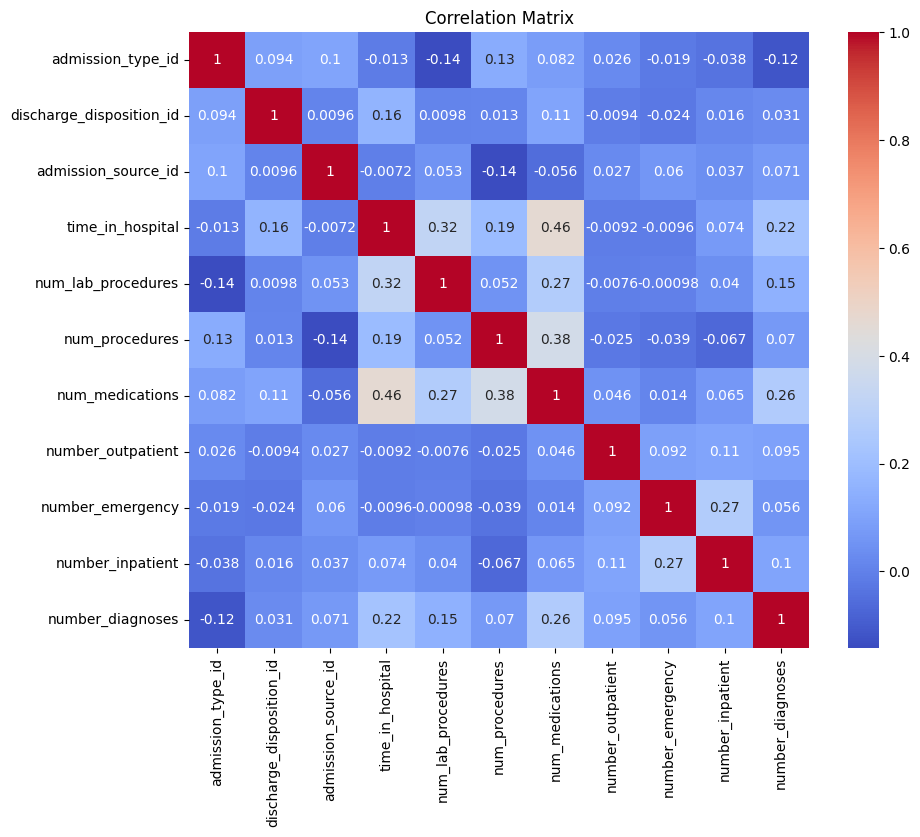

In [10]:
#Before preprocessing, I wanted to check the Multicollinearity

#Extract numerical values
numeric_cols = df_processed.select_dtypes(include=np.number).columns.tolist()

#Remove the target (Readmitted)
x = df_processed.drop('readmitted', axis = 1)

df_numeric = df_processed[numeric_cols]

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = df_numeric.columns
vif['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
vif


,Features,VIF
0,admission_type_id,2.817009
1,discharge_disposition_id,1.513995
2,admission_source_id,3.054839
3,time_in_hospital,4.418992
4,num_lab_procedures,6.041418
5,num_procedures,1.976419
6,num_medications,7.547775
7,number_outpatient,1.115923
8,number_emergency,1.136293
9,number_inpatient,1.383928


We can conclude there is no significant multicollinearity among original nmerical features (> 0.7)

#Feature Engineering

**Set the Binary target (y)**

In [12]:
# Change the target (readmitted) into binary
df_processed['readmitted'] = df_processed['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

**Summarize Medication count features**

In [13]:
medications = ["metformin","repaglinide","nateglinide","chlorpropamide","glimepiride","examide","acetohexamide","glipizide","glyburide","tolbutamide","pioglitazone","rosiglitazone","acarbose","miglitol","troglitazone","tolazamide","insulin","citoglipton","glyburide-metformin","glipizide-metformin","glimepiride-pioglitazone","metformin-rosiglitazone","metformin-pioglitazone"]
#Already proved there's no missing values in Medication columns, so we skip missing check

#Exclude Insulin from medication features since it has more correlation with Readmission
non_insulin_cols = [c for c in medications if 'insulin' not in c]

#Summarize the features
df_processed['oral_any_active'] = (df_processed[non_insulin_cols].ne('No')).any(axis=1).astype(int)
df_processed['oral_active_count'] = (df_processed[non_insulin_cols].ne('No')).sum(axis=1).astype(int)
df_processed['oral_up_count'] = (df_processed[non_insulin_cols] == 'Up').sum(axis=1).astype(int)
df_processed['oral_down_count'] = (df_processed[non_insulin_cols] == 'Down').sum(axis=1).astype(int)
df_processed['oral_steady_count'] = (df_processed[non_insulin_cols] == 'Steady').sum(axis=1).astype(int)

#Combinations
combo_cols = [c for c in non_insulin_cols if '-' in c]
df_processed['oral_combo_any_active'] = (df_processed[combo_cols].ne('No')).any(axis=1).astype(int) if combo_cols else 0



In [14]:
#Medications encoding


map = {'No':0, 'Down':1, 'Steady':2, 'Up':3}
for m in medications:
  df_processed[m] = df_processed[m].map(map).astype('Int64')

**Grouping diag-01~03 by Elixhauster**

In [15]:
#Generated from Chat GPT 5
import re
import pandas as pd

file_path = r'/content/drive/My Drive/NUS/IT5006/Project/comformat2012-2015.txt'  # Keep your path

mapping = []

with open(file_path, 'r', encoding='latin1') as f:  # Added encoding to prevent garbled characters
    in_rcom = False
    current_codes = []

    for raw_line in f:
        # Remove comments (use only the part before /* ... */)
        line = raw_line.split('/*')[0].strip()
        if not line:
            continue

        # Detect the start of $RCOMFMT (ignore other VALUEs)
        if not in_rcom:
            if re.match(r'^\s*VALUE\s+\$RCOMFMT\b', line):
                in_rcom = True
            continue

        # Stop when reaching "Other = " " in $RCOMFMT (don't read DRG etc. after that)
        if re.match(r'^\s*Other\s*=', line):
            break

        # If the line contains '=', group the previous lines and assign them to the same category
        if '=' in line:
            left, right = line.split('=', 1)
            # Include codes on the left side of the current line
            codes_this_line = [c.strip().strip(',') for c in left.strip().split(',') if c.strip()]
            current_codes.extend(codes_this_line)

            # Category (the first quoted part on the right side)
            cat_match = re.search(r'"([A-Z0-9_]+)"', right)
            category = cat_match.group(1) if cat_match else None

            # Assign the accumulated codes to the category
            for code in current_codes:
                code = code.strip().strip('"')
                if '-' in code:
                    start, end = [p.strip().strip('"') for p in code.split('-', 1)]
                    mapping.append((start, end, category))
                else:
                    mapping.append((code, code, category))

            # Reset the buffer
            current_codes = []
        else:
            # Accumulate codes until '=' appears
            codes = [c.strip().strip(',') for c in line.split(',') if c.strip()]
            current_codes.extend(codes)

print(f'{len(mapping)} mapping rows were read.')
print(mapping[:5])  # Check the first few

235 mapping rows were read.
[('39891', '39891', 'CHF'), ('4280 ', '4289', 'CHF'), ('09320', '09324', 'VALVE'), ('3940 ', '3971', 'VALVE'), ('3979 ', '3979 ', 'VALVE')]


In [16]:
def pad_code(code: str) -> str:
    """
    Normalize ICD-9 codes to match SAS $RCOMFMT comparison method (5 characters right-padded with spaces)
    - Remove decimal points (250.83 -> 25083, 250.7 -> 25070)
    - Right-pad with zeros if less than 5 digits (276 -> 27600, 414 -> 41400)
    - Handle codes starting with letters (V/E codes) (V27 -> V2700)
    """
    if code is None or (isinstance(code, float) and pd.isna(code)):
        return None
    s = str(code).upper().strip()
    if s == "" or s in ["NAN", "NA"]:
        return None
    # Remove decimal points
    s = s.replace(".", "")
    # Remove non-alphanumeric characters
    s = re.sub(r'[^A-Z0-9]', '', s)
    # Right-pad with zeros to 5 digits
    if len(s) < 5:
        s = s.ljust(5, "0")
    # Further right-pad with spaces to a fixed length (SAS compares with space padding)
    return s.ljust(5)

# Normalize the mapping using the same rule
mapping_padded = [(pad_code(start), pad_code(end), cat) for start, end, cat in mapping]

def map_icd_to_elix(icd9_code: str):
    """Map a single ICD-9 code to an Elixhauser category (returns None if no match)"""
    pc = pad_code(icd9_code)
    if pc is None:
        return "Unknown"
    for start, end, cat in mapping_padded:
        if start <= pc <= end:
            return cat
    return "Unknown"

In [17]:
print(map_icd_to_elix('428'))     # CHF
print(map_icd_to_elix('250.83'))  # DMCX ✅
print(map_icd_to_elix('250.7'))   # DMCX ✅
print(map_icd_to_elix('276'))     # LYTES ✅
print(map_icd_to_elix('414'))     # -> None
print(map_icd_to_elix('V27'))     # -> None
print(map_icd_to_elix('8'))       # -> None


CHF
DMCX
DMCX
LYTES
Unknown
Unknown
Unknown


In [18]:
import pandas as pd

# Assume df is the original dataframe
for col in ['diag_1', 'diag_2', 'diag_3']:
    new_col = f'{col}_elix'
    df_processed[new_col] = df[col].apply(map_icd_to_elix)

display(df_processed[['diag_1', 'diag_1_elix', 'diag_2', 'diag_2_elix', 'diag_3', 'diag_3_elix']].head(15))

# Drop the unnecessary columns
df_processed = df_processed.drop(['diag_1','diag_2','diag_3'], axis =1)

,diag_1,diag_1_elix,diag_2,diag_2_elix,diag_3,diag_3_elix
0,250.83,DMCX,NaN,Unknown,NaN,Unknown
1,276,LYTES,250.01,DM,255,Unknown
2,648,DM,250,DM,V27,Unknown
3,8,Unknown,250.43,DMCX,403,HRENWORF
4,197,METS,157,TUMOR,250,DM
5,414,Unknown,411,Unknown,250,DM
6,414,Unknown,411,Unknown,V45,Unknown
7,428,CHF,492,CHRNLUNG,250,DM
8,398,Unknown,427,Unknown,38,Unknown
9,434,Unknown,198,METS,486,Unknown


In [19]:
# Get unique values and their counts for the new columns
diag_1_elix_counts = df_processed['diag_1_elix'].value_counts()
diag_2_elix_counts = df_processed['diag_2_elix'].value_counts()
diag_3_elix_counts = df_processed['diag_3_elix'].value_counts()

# Calculate proportions
diag_1_elix_props = df_processed['diag_1_elix'].value_counts(normalize=True)
diag_2_elix_props = df_processed['diag_2_elix'].value_counts(normalize=True)
diag_3_elix_props = df_processed['diag_3_elix'].value_counts(normalize=True)

# Create DataFrames for counts and proportions
counts_df = pd.DataFrame({
    'diag_1_elix Counts': diag_1_elix_counts,
    'diag_2_elix Counts': diag_2_elix_counts,
    'diag_3_elix Counts': diag_3_elix_counts
})

props_df = pd.DataFrame({
    'diag_1_elix Proportions': diag_1_elix_props,
    'diag_2_elix Proportions': diag_2_elix_props,
    'diag_3_elix Proportions': diag_3_elix_props
})

print('Counts for Elixhauser mapped diagnostic codes:')
display(counts_df)

print('\nProportions for Elixhauser mapped diagnostic codes:')
display(props_df.sort_values(by='diag_1_elix Proportions', ascending=False)) # Sort by diag_1_elix proportions

Counts for Elixhauser mapped diagnostic codes:


,diag_1_elix Counts,diag_2_elix Counts,diag_3_elix Counts
ALCOHOL,185,1059,1168
ANEMDEF,20,17,35
ARTH,80,215,214
BLDLOSS,317,599,396
CHF,6663,6459,4412
CHRNLUNG,3543,5910,4001
COAG,45,110,116
DEPRESS,94,133,261
DM,4010,10538,14058
DMCX,4936,2505,3028



Proportions for Elixhauser mapped diagnostic codes:


,diag_1_elix Proportions,diag_2_elix Proportions,diag_3_elix Proportions
Unknown,0.699788,0.518376,0.492808
CHF,0.067071,0.065017,0.044412
DMCX,0.049686,0.025216,0.030480
DM,0.040365,0.106077,0.141510
CHRNLUNG,0.035664,0.059491,0.040275
TUMOR,0.018602,0.008345,0.004832
LYTES,0.018512,0.066326,0.049858
PSYCH,0.014294,0.006020,0.005587
PERIVASC,0.009925,0.004550,0.002939
HRENWORF,0.004983,0.027611,0.022921


**Grouping high cardinal category**

In [20]:
#age grouping
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df_processed['age'] = df_processed['age'].map(age_mapping)


In [21]:
print(df_processed['A1Cresult'].unique())
print(df['A1Cresult'].unique())

[nan '>7' '>8' 'Norm']
[nan '>7' '>8' 'Norm']


In [22]:
#A1Cresult and Max_glu_serum

def encode_a1c_glucose(df):
  df = df.copy()
  a1c_map = {'>8': 2, '>7': 1, 'Norm': 0, 'None': -99}
  glu_map = {'>300':3, '>200': 2, 'Norm': 0, 'None': -99}
  df['A1Cresult'] = df['A1Cresult'].map(a1c_map)
  df['max_glu_serum'] = df['max_glu_serum'].map(glu_map)
  return df

df_processed['A1Cresult'] = df_processed['A1Cresult'].fillna('None')
df_processed['max_glu_serum'] = df_processed['max_glu_serum'].fillna('None')
df_processed = encode_a1c_glucose(df_processed)

In [23]:
# Group payer_code by frequency
for col in ['payer_code']:
    top_categories = df_processed[col].value_counts().nlargest(10).index
    df_processed[col] = np.where(df_processed[col].isin(top_categories), df_processed[col], 'Other')

**Medical specialty gropuing by readmission ratio put others together**

In [24]:
'''
Group medical_specialty by readmision ratio
Medical Specialty: Remaining Top <30 Readmission ratio and aggregate the rest into 'others'
'''
import re
import numpy as np
import pandas as pd

def top_by_readmit_ratio (df, col, target='readmitted', pos_label=1,min_count=0,top_n=10):
  tab = (
      df.groupby(col)[target]
        .agg(count_total='size', count_pos='sum')
        .assign(prop_pos=lambda x: x['count_pos'].astype(int) / x['count_total'])
        .sort_values(by='prop_pos', ascending=False)
  )
  if min_count >0:
    tab = tab[tab['count_total'] >= min_count]
  top_idx = tab.head(top_n).index
  return list(top_idx), tab


#Top_n = 10, min_count = 100
TOP_N = 10
MIN_COUNT = 100

top10_specialty, specialty_table = top_by_readmit_ratio(
    df_processed, 'medical_specialty',  target='readmitted', min_count=MIN_COUNT, top_n=TOP_N)
print('Top10: ',top10_specialty)
display(specialty_table.head(15))

Top10:  ['Hematology/Oncology', 'Oncology', 'Nephrology', 'PhysicalMedicineandRehabilitation', 'Surgery-Vascular', 'Psychiatry', 'Family/GeneralPractice', 'Unknown', 'InternalMedicine', 'Emergency/Trauma']


,count_total,count_pos,prop_pos
medical_specialty,,,
Hematology/Oncology,187,40,0.213904
Oncology,319,64,0.200627
Nephrology,1539,248,0.161144
PhysicalMedicineandRehabilitation,391,60,0.153453
Surgery-Vascular,525,74,0.140952
Psychiatry,853,104,0.121923
Family/GeneralPractice,7252,879,0.121208
Unknown,48616,5753,0.118336
InternalMedicine,14237,1642,0.115333


In [25]:
#Convert into column (Retain top10 and change the rest into 'others')

df_processed['medical_specialty'] = df_processed['medical_specialty'].apply(lambda x: x if x in top10_specialty else 'others')

In [26]:
# Get missing values, unique values, and data types
missing_values = df_processed.isnull().sum()
unique_values = df_processed.nunique()
data_types = df_processed.dtypes

# Create a DataFrame to display the information in a table format
info_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Unique Values': unique_values,
    'Data Type': data_types
})

print('DataFrame Information:')
display(info_df)

DataFrame Information:


,Missing Values,Unique Values,Data Type
race,0,6,object
gender,0,3,object
age,0,10,int64
admission_type_id,0,8,int64
discharge_disposition_id,0,21,int64
admission_source_id,0,17,int64
time_in_hospital,0,14,int64
payer_code,0,11,object
medical_specialty,0,11,object
num_lab_procedures,0,118,int64


**Emphasize Clinical Metrics Distribution Histograms**


In [27]:
def add_engineered_features(df_processed, original_df=None):
  dfp = df_processed.copy()

  # 1) Utilization bundle
  for c in ['number_outpatient',	'number_emergency',	'number_inpatient']:
    if c not in dfp.columns: dfp[c] = 0
  dfp['util_sum'] = dfp['number_outpatient'] + dfp['number_emergency'] + dfp['number_inpatient']
  dfp['ever_inpatient'] = (dfp['number_inpatient'] > 0).astype(int)
  dfp['frequent_ER'] = (dfp['number_emergency'] >= 2).astype(int)

  #2 Polypharmacy
  dfp['poly6'] = (dfp['num_medications'] >= 6).astype(int)
  dfp['poly10'] = (dfp['num_medications'] >= 10).astype(int)

  #3) Insulin change flags
  dfp['insulin_up'] = (dfp['insulin'] == 3).astype(int)
  dfp['insulin_down'] = (dfp['insulin'] == 1).astype(int)
  dfp['insulin_steady'] = (dfp['insulin'] ==2).astype(int)

  #4) LACE-like sum
  for c in ['time_in_hospital', 'number_emergency', 'number_diagnoses']:
    if c not in dfp.columns: dfp[c] = 0
  dfp['lace_proxy'] = (
      dfp['time_in_hospital'].clip(upper=14) +
      dfp['number_emergency'].clip(upper=4) +
      dfp['number_diagnoses'].clip(upper=16)
  )

  #5) Per-day intensity
  dfp['labs_per_day'] = (dfp['num_lab_procedures'] / (dfp['time_in_hospital'].replace(0,1)))
  dfp['meds_per_day'] = (dfp['num_medications'] / (dfp['time_in_hospital'].replace(0,1)))
  dfp['procs_per_day'] = (dfp['num_procedures'] / (dfp['time_in_hospital'].replace(0,1)))

  #7) Procedures x Lab procedures
  dfp['proc_per_lab'] = dfp['num_lab_procedures'] * dfp['num_procedures'].clip(upper=100)

  #8) AC1, glu high flags
  dfp['AC1_high']= (dfp['A1Cresult'] >= 1).astype(int)
  dfp['glu_high'] = (dfp['max_glu_serum'] >= 2).astype(int)

  return dfp

In [28]:
df_processed = add_engineered_features(df_processed, original_df = df)

In [29]:
df_processed

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,oral_any_active,oral_active_count,oral_up_count,oral_down_count,oral_steady_count,oral_combo_any_active,diag_1_elix,diag_2_elix,diag_3_elix,util_sum,ever_inpatient,frequent_ER,poly6,poly10,insulin_up,insulin_down,insulin_steady,lace_proxy,labs_per_day,meds_per_day,procs_per_day,proc_per_lab,AC1_high,glu_high
0,Caucasian,Female,5,6,25,1,1,Unknown,others,41,0,1,0,0,0,1,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,No,0,0,0,0,0,0,0,DMCX,Unknown,Unknown,0,0,0,0,0,0,0,0,2,41.000000,1.000000,0.0,0,0,0
1,Caucasian,Female,15,1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,9,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,Ch,Yes,0,0,0,0,0,0,0,LYTES,DM,Unknown,0,0,0,1,1,1,0,0,12,19.666667,6.000000,0.0,0,0,0
2,AfricanAmerican,Female,25,1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,6,-99,-99,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No,Yes,0,1,1,0,0,1,0,DM,DM,Unknown,3,1,0,1,1,0,0,0,8,5.500000,6.500000,2.5,55,0,0
3,Caucasian,Male,35,1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,7,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,Ch,Yes,0,0,0,0,0,0,0,Unknown,DMCX,HRENWORF,0,0,0,1,1,1,0,0,9,22.000000,8.000000,0.5,44,0,0
4,Caucasian,Male,45,1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,5,-99,-99,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,Ch,Yes,0,1,1,0,0,1,0,METS,TUMOR,DM,0,0,0,1,0,0,0,1,6,51.000000,8.000000,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,1,3,7,3,MC,Unknown,51,0,16,0,0,0,9,-99,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,1,1,0,0,1,0,DM,ALCOHOL,Unknown,0,0,0,1,1,0,1,0,12,17.000000,5.333333,0.0,0,1,0
101762,AfricanAmerican,Female,85,1,4,5,5,MC,Unknown,33,3,18,0,0,1,9,-99,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,No,Yes,0,0,0,0,0,0,0,Unknown,LYTES,Unknown,1,1,0,1,1,0,0,1,14,6.600000,3.600000,0.6,99,0,0
101763,Caucasian,Male,75,1,1,7,1,MC,Unknown,53,0,9,1,0,0,13,-99,-99,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Ch,Yes,0,1,1,0,0,1,0,Unknown,Unknown,PSYCH,1,0,0,1,0,0,1,0,14,53.000000,9.000000,0.0,0,0,0
101764,Caucasian,Female,85,2,3,7,10,MC,others,45,2,21,0,0,1,9,-99,-99,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,3,0,0,0,0,0,Ch,Yes,0,1,2,0,0,2,0,Unknown,Unknown,Unknown,1,1,0,1,1,1,0,0,19,4.500000,2.100000,0.2,90,0,0


In [30]:
# Save the processed dataframe to a CSV file
output_path = r'/content/drive/My Drive/NUS/IT5006/Project/Diabetec_data_processed.csv'
df_processed.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")

Processed data saved to /content/drive/My Drive/NUS/IT5006/Project/Diabetec_data_processed.csv


**Encoding**

In [31]:
y = ['readmitted']
one_hot_encoding = ['race','gender','change','diabetesMed','admission_type_id','discharge_disposition_id','admission_source_id','payer_code','medical_specialty','diag_1_elix', 'diag_2_elix', 'diag_3_elix']
Scaling_cols = [c for c in df_processed.columns if c not in y + one_hot_encoding]
# Collect all columns from the defined lists
all_listed_columns = y + one_hot_encoding + Scaling_cols

# Get all columns from df_processed
all_df_processed_columns = df_processed.columns.tolist()

# Find columns in df_processed that are not in the defined lists
missing_columns = [col for col in all_df_processed_columns if col not in all_listed_columns]

# Print the missing columns
if missing_columns:
    print("The following columns in df_processed are not included in your feature groupings:")
    print(missing_columns)
else:
    print("All columns in df_processed are included in your feature groupings.")

All columns in df_processed are included in your feature groupings.


In [32]:
#One Hot Encoding
df_final = pd.get_dummies(df_processed, columns=one_hot_encoding, drop_first=True)




In [33]:
print(df_final.head())


   age  time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0    5                 1                  41               0                1   
1   15                 3                  59               0               18   
2   25                 2                  11               5               13   
3   35                 2                  44               1               16   
4   45                 1                  51               0                8   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0                  0                 0                 0                 1   
1                  0                 0                 0                 9   
2                  2                 0                 1                 6   
3                  0                 0                 0                 7   
4                  0                 0                 0                 5   

   max_glu_serum  A1Cresult  metformin  repa

In [34]:
#Check if any Nan or infinite values remaining
nan_counts = df_final.isna().sum()
inf_counts = df_final.isin([np.inf, -np.inf]).sum()

print("Missing values per column:")
print(nan_counts[nan_counts > 0])

print("\nInfinite values per column:")
print(inf_counts[inf_counts > 0])

if nan_counts.sum() == 0 and inf_counts.sum() == 0:
    print("\nNo missing or infinite values found in the dataframe.")
else:
    print("\nMissing or infinite values found. Please handle them before modeling.")

Missing values per column:
Series([], dtype: int64)

Infinite values per column:
Series([], dtype: Int64)

No missing or infinite values found in the dataframe.


**Preparation for Model Evaluation**

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Corrected import
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


X = df_final.drop('readmitted', axis=1)
y = df_final['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

Scaler = RobustScaler()
X_train[Scaling_cols] = Scaler.fit_transform(X_train[Scaling_cols])
X_test[Scaling_cols] = Scaler.transform(X_test[Scaling_cols])

In [36]:
df_final

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,readmitted,oral_any_active,oral_active_count,oral_up_count,oral_down_count,oral_steady_count,oral_combo_any_active,util_sum,ever_inpatient,frequent_ER,poly6,poly10,insulin_up,insulin_down,insulin_steady,lace_proxy,labs_per_day,meds_per_day,procs_per_day,proc_per_lab,AC1_high,glu_high,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Male,gender_Unknown/Invalid,change_No,diabetesMed_Yes,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,payer_code_CM,payer_code_CP,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_OG,payer_code_Other,payer_code_SP,payer_code_UN,payer_code_Unknown,medical_specialty_Family/GeneralPractice,medical_specialty_Hematology/Oncology,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Oncology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_Psychiatry,medical_specialty_Surgery-Vascular,medical_specialty_Unknown,medical_specialty_others,diag_1_elix_ANEMDEF,diag_1_elix_ARTH,diag_1_elix_BLDLOSS,diag_1_elix_CHF,diag_1_elix_CHRNLUNG,diag_1_elix_COAG,diag_1_elix_DEPRESS,diag_1_elix_DM,diag_1_elix_DMCX,diag_1_elix_DRUG,diag_1_elix_HHRWOHRF,diag_1_elix_HRENWORF,diag_1_elix_HTN,diag_1_elix_HTNCX,diag_1_elix_HTNWOCHF,diag_1_elix_HYPOTHY,diag_1_elix_LIVER,diag_1_elix_LYMPH,diag_1_elix_LYTES,diag_1_elix_METS,diag_1_elix_NEURO,diag_1_elix_OBESE,diag_1_elix_PARA,diag_1_elix_PERIVASC,diag_1_elix_PSYCH,diag_1_elix_PULMCIRC,diag_1_elix_RENLFAIL,diag_1_elix_TUMOR,diag_1_elix_Unknown,diag_1_elix_VALVE,diag_1_elix_WGHTLOSS,diag_2_elix_ANEMDEF,diag_2_elix_ARTH,diag_2_elix_BLDLOSS,diag_2_elix_CHF,diag_2_elix_CHRNLUNG,diag_2_elix_COAG,diag_2_elix_DEPRESS,diag_2_elix_DM,diag_2_elix_DMCX,diag_2_elix_DRUG,diag_2_elix_HHRWOHRF,diag_2_elix_HRENWORF,diag_2_elix_HTN,diag_2_elix_HTNCX,diag_2_elix_HTNWOCHF,diag_2_elix_HYPOTHY,diag_2_elix_LIVER,diag_2_elix_LYMPH,diag_2_elix_LYTES,diag_2_elix_METS,diag_2_elix_NEURO,diag_2_elix_OBESE,diag_2_elix_PARA,diag_2_elix_PERIVASC,diag_2_elix_PSYCH,diag_2_elix_PULMCIRC,diag_2_elix_RENLFAIL,diag_2_elix_TUMOR,diag_2_elix_Unknown,diag_2_elix_VALVE,diag_2_elix_WGHTLOSS,diag_3_elix_ANEMDEF,diag_3_elix_ARTH,diag_3_elix_BLDLOSS,diag_3_elix_CHF,diag_3_elix_CHRNLUNG,diag_3_elix_COAG,diag_3_elix_DEPRESS,diag_3_elix_DM,diag_3_elix_DMCX,diag_3_elix_DRUG,diag_3_elix_HHRWOHRF,diag_3_elix_HRENWORF,diag_3_elix_HTN,diag_3_elix_HTNCX,diag_3_elix_HTNWOCHF,diag_3_elix_HYPOTHY,diag_3_elix_LIVER,diag_3_elix_LYMPH,diag_3_elix_LYTES,diag_3_elix_METS,diag_3_elix_NEURO,diag_3_elix_OBESE,diag_3_eli

In [37]:
#Helpers

def tune_threshold_for_f1(y_true, proba, grid=np.linspace(0.05,0.40,36)):
  best_t, best_f1 = 0.5,-1
  for t in grid:
    y_pred = (proba >= t).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
      best_f1 = f1
      best_t = t
  return best_t, best_f1

#Result evaluation
def report_all (y_true, y_pred, proba):
  print(confusion_matrix(y_true, y_pred))
  print('Classification report: ')
  print(classification_report(y_true, y_pred))
  print('ROC AUC')
  print(roc_auc_score(y_true, proba))
  print('PR AUC')
  print(average_precision_score(y_true, proba))

#class imbalance helper for LightGBM
def pos_weight_from_y(y):
  y = np.asarray(y)
  pos = (y==1).sum()
  neg = (y==0).sum()
  return max(neg / max(pos,1), 1.0)


#KMEANS

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [39]:

candidate_NUM = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
                 'number_inpatient', 'number_diagnoses', 'age', 'oral_active_count', 'oral_up_count', 'oral_down_count', 'oral_steady_count'
]

cluster_num_cols = [c for c in candidate_NUM if c in X_train_raw.columns]

scaler_km = StandardScaler()
Z_train = scaler_km.fit_transform(X_train_raw[cluster_num_cols])
Z_test = scaler_km.transform(X_test_raw[cluster_num_cols])


In [40]:
# Fit final Kmeans and append one-hot cluster features
def one_hot_k_labels(labels, k, prefix='km'):
  d = pd.get_dummies(pd.Series(labels), prefix=prefix)
  for i in range(k):
    col = f"{prefix}_{i}"
    if col not in d.columns:
      d[col] = 0
  return d[[f"{prefix}_{i}" for i in range(k)]]
K_FINAL = 6 #Based on inertia, silhouette, db_score, we identified the best K
km_final = KMeans(n_clusters=K_FINAL, n_init = 10, random_state=42).fit(Z_train)
labels_tr = km_final.predict(Z_train)
labels_te = km_final.predict(Z_test)

X_train_km = pd.concat([X_train.reset_index(drop=True), one_hot_k_labels(labels_tr, K_FINAL)], axis=1)
X_test_km = pd.concat([X_test.reset_index(drop=True), one_hot_k_labels(labels_te, K_FINAL)], axis=1)

print('Added cluster columns:', X_train_km.columns[-K_FINAL:])

Added cluster columns: Index(['km_0', 'km_1', 'km_2', 'km_3', 'km_4', 'km_5'], dtype='object')


In [41]:
X_train_km

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,oral_any_active,oral_active_count,oral_up_count,oral_down_count,oral_steady_count,oral_combo_any_active,util_sum,ever_inpatient,frequent_ER,poly6,poly10,insulin_up,insulin_down,insulin_steady,lace_proxy,labs_per_day,meds_per_day,procs_per_day,proc_per_lab,AC1_high,glu_high,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Male,gender_Unknown/Invalid,change_No,diabetesMed_Yes,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,payer_code_CM,payer_code_CP,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_OG,payer_code_Other,payer_code_SP,payer_code_UN,payer_code_Unknown,medical_specialty_Family/GeneralPractice,medical_specialty_Hematology/Oncology,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Oncology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_Psychiatry,medical_specialty_Surgery-Vascular,medical_specialty_Unknown,medical_specialty_others,diag_1_elix_ANEMDEF,diag_1_elix_ARTH,diag_1_elix_BLDLOSS,diag_1_elix_CHF,diag_1_elix_CHRNLUNG,diag_1_elix_COAG,diag_1_elix_DEPRESS,diag_1_elix_DM,diag_1_elix_DMCX,diag_1_elix_DRUG,diag_1_elix_HHRWOHRF,diag_1_elix_HRENWORF,diag_1_elix_HTN,diag_1_elix_HTNCX,diag_1_elix_HTNWOCHF,diag_1_elix_HYPOTHY,diag_1_elix_LIVER,diag_1_elix_LYMPH,diag_1_elix_LYTES,diag_1_elix_METS,diag_1_elix_NEURO,diag_1_elix_OBESE,diag_1_elix_PARA,diag_1_elix_PERIVASC,diag_1_elix_PSYCH,diag_1_elix_PULMCIRC,diag_1_elix_RENLFAIL,diag_1_elix_TUMOR,diag_1_elix_Unknown,diag_1_elix_VALVE,diag_1_elix_WGHTLOSS,diag_2_elix_ANEMDEF,diag_2_elix_ARTH,diag_2_elix_BLDLOSS,diag_2_elix_CHF,diag_2_elix_CHRNLUNG,diag_2_elix_COAG,diag_2_elix_DEPRESS,diag_2_elix_DM,diag_2_elix_DMCX,diag_2_elix_DRUG,diag_2_elix_HHRWOHRF,diag_2_elix_HRENWORF,diag_2_elix_HTN,diag_2_elix_HTNCX,diag_2_elix_HTNWOCHF,diag_2_elix_HYPOTHY,diag_2_elix_LIVER,diag_2_elix_LYMPH,diag_2_elix_LYTES,diag_2_elix_METS,diag_2_elix_NEURO,diag_2_elix_OBESE,diag_2_elix_PARA,diag_2_elix_PERIVASC,diag_2_elix_PSYCH,diag_2_elix_PULMCIRC,diag_2_elix_RENLFAIL,diag_2_elix_TUMOR,diag_2_elix_Unknown,diag_2_elix_VALVE,diag_2_elix_WGHTLOSS,diag_3_elix_ANEMDEF,diag_3_elix_ARTH,diag_3_elix_BLDLOSS,diag_3_elix_CHF,diag_3_elix_CHRNLUNG,diag_3_elix_COAG,diag_3_elix_DEPRESS,diag_3_elix_DM,diag_3_elix_DMCX,diag_3_elix_DRUG,diag_3_elix_HHRWOHRF,diag_3_elix_HRENWORF,diag_3_elix_HTN,diag_3_elix_HTNCX,diag_3_elix_HTNWOCHF,diag_3_elix_HYPOTHY,diag_3_elix_LIVER,diag_3_elix_LYMPH,diag_3_elix_LYTES,diag_3_elix_METS,diag_3_elix_NEURO,diag_3_elix_OBESE,diag_3_elix_PARA,diag

In [42]:
X_test_km

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,oral_any_active,oral_active_count,oral_up_count,oral_down_count,oral_steady_count,oral_combo_any_active,util_sum,ever_inpatient,frequent_ER,poly6,poly10,insulin_up,insulin_down,insulin_steady,lace_proxy,labs_per_day,meds_per_day,procs_per_day,proc_per_lab,AC1_high,glu_high,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Male,gender_Unknown/Invalid,change_No,diabetesMed_Yes,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25,payer_code_CM,payer_code_CP,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_OG,payer_code_Other,payer_code_SP,payer_code_UN,payer_code_Unknown,medical_specialty_Family/GeneralPractice,medical_specialty_Hematology/Oncology,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Oncology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_Psychiatry,medical_specialty_Surgery-Vascular,medical_specialty_Unknown,medical_specialty_others,diag_1_elix_ANEMDEF,diag_1_elix_ARTH,diag_1_elix_BLDLOSS,diag_1_elix_CHF,diag_1_elix_CHRNLUNG,diag_1_elix_COAG,diag_1_elix_DEPRESS,diag_1_elix_DM,diag_1_elix_DMCX,diag_1_elix_DRUG,diag_1_elix_HHRWOHRF,diag_1_elix_HRENWORF,diag_1_elix_HTN,diag_1_elix_HTNCX,diag_1_elix_HTNWOCHF,diag_1_elix_HYPOTHY,diag_1_elix_LIVER,diag_1_elix_LYMPH,diag_1_elix_LYTES,diag_1_elix_METS,diag_1_elix_NEURO,diag_1_elix_OBESE,diag_1_elix_PARA,diag_1_elix_PERIVASC,diag_1_elix_PSYCH,diag_1_elix_PULMCIRC,diag_1_elix_RENLFAIL,diag_1_elix_TUMOR,diag_1_elix_Unknown,diag_1_elix_VALVE,diag_1_elix_WGHTLOSS,diag_2_elix_ANEMDEF,diag_2_elix_ARTH,diag_2_elix_BLDLOSS,diag_2_elix_CHF,diag_2_elix_CHRNLUNG,diag_2_elix_COAG,diag_2_elix_DEPRESS,diag_2_elix_DM,diag_2_elix_DMCX,diag_2_elix_DRUG,diag_2_elix_HHRWOHRF,diag_2_elix_HRENWORF,diag_2_elix_HTN,diag_2_elix_HTNCX,diag_2_elix_HTNWOCHF,diag_2_elix_HYPOTHY,diag_2_elix_LIVER,diag_2_elix_LYMPH,diag_2_elix_LYTES,diag_2_elix_METS,diag_2_elix_NEURO,diag_2_elix_OBESE,diag_2_elix_PARA,diag_2_elix_PERIVASC,diag_2_elix_PSYCH,diag_2_elix_PULMCIRC,diag_2_elix_RENLFAIL,diag_2_elix_TUMOR,diag_2_elix_Unknown,diag_2_elix_VALVE,diag_2_elix_WGHTLOSS,diag_3_elix_ANEMDEF,diag_3_elix_ARTH,diag_3_elix_BLDLOSS,diag_3_elix_CHF,diag_3_elix_CHRNLUNG,diag_3_elix_COAG,diag_3_elix_DEPRESS,diag_3_elix_DM,diag_3_elix_DMCX,diag_3_elix_DRUG,diag_3_elix_HHRWOHRF,diag_3_elix_HRENWORF,diag_3_elix_HTN,diag_3_elix_HTNCX,diag_3_elix_HTNWOCHF,diag_3_elix_HYPOTHY,diag_3_elix_LIVER,diag_3_elix_LYMPH,diag_3_elix_LYTES,diag_3_elix_METS,diag_3_elix_NEURO,diag_3_elix_OBESE,diag_3_elix_PARA,diag

#Logistic Regression

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#Train based on logistic Regression
log_model = LogisticRegression(class_weight = 'balanced', max_iter=2000, penalty = 'l1', solver = 'liblinear')
log_model.fit(X_train_km, y_train)

#Execute
y_pred = log_model.predict(X_test_km)

#Analyze the result
report_all(y_test, y_pred, log_model.predict_proba(X_test_km)[:, 1])

[[11937  5655]
 [ 1010  1267]]
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     17592
           1       0.18      0.56      0.28      2277

    accuracy                           0.66     19869
   macro avg       0.55      0.62      0.53     19869
weighted avg       0.84      0.66      0.72     19869

ROC AUC
0.6694632326787258
PR AUC
0.21818196271549561


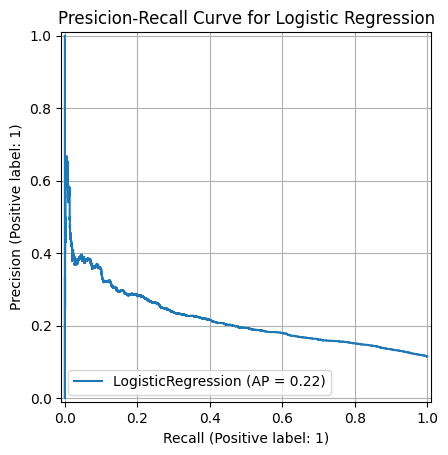

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

#Plot the Precision-recall curve
PrecisionRecallDisplay.from_estimator(log_model, X_test_km, y_test)
plt.title('Presicion-Recall Curve for Logistic Regression')
plt.grid(True)
plt.show()


Apply RandomOverSampler

In [45]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_km, y_train)

log_model_ros = LogisticRegression(class_weight = None, max_iter=2000, penalty = 'l1', solver = 'liblinear')
log_model_ros.fit(X_resampled, y_resampled)

y_pred = log_model_ros.predict(X_test_km)

report_all(y_test, y_pred, log_model_ros.predict_proba(X_test_km)[:, 1])

[[11925  5667]
 [ 1006  1271]]
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     17592
           1       0.18      0.56      0.28      2277

    accuracy                           0.66     19869
   macro avg       0.55      0.62      0.53     19869
weighted avg       0.84      0.66      0.72     19869

ROC AUC
0.6693939563697556
PR AUC
0.21827551949482735


In [46]:
'''
#Grid search for Logistic Regression

from sklearn.model_selection import GridSearchCV
#Grid over penalty and C

#Split a validation from TRAIN
X_tr, X_va, y_tr,y_va = train_test_split(
    X_train_km, y_train, test_size = 0.2, stratify = y_train, random_state = 42
)

lr = LogisticRegression(solver='saga',class_weight = 'balanced', max_iter=3000)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.25, 0.5, 1.0, 2.0]
}
gs = GridSearchCV(lr, param_grid, cv=3, scoring='average_precision', n_jobs=1,verbose=0)
gs.fit(X_tr, y_tr)
best_lr = gs.best_estimator_
print('Best parameters found ', gs.best_params_)
print('Best score found ', gs.best_score_)

# threhold on validation for F1
prova_va = best_lr.predict_proba(X_va)[:, 1]
t_star, f1_star = tune_threshold_for_f1(y_va.values, prova_va)

#train on full train & evaluation on TEST with t*
best_lr.fit(X_train_km, y_train)
proba_test = best_lr.predict_proba(X_test_km)[:, 1]
yhat_test = (proba_test >= t_star).astype(int)

print('Model evaluation after grid search')
report_all(y_test, yhat_test, proba_test)
'''

"\n#Grid search for Logistic Regression\n\nfrom sklearn.model_selection import GridSearchCV\n#Grid over penalty and C\n\n#Split a validation from TRAIN\nX_tr, X_va, y_tr,y_va = train_test_split(\n    X_train_km, y_train, test_size = 0.2, stratify = y_train, random_state = 42\n)\n\nlr = LogisticRegression(solver='saga',class_weight = 'balanced', max_iter=3000)\nparam_grid = {\n    'penalty': ['l1', 'l2'],\n    'C': [0.25, 0.5, 1.0, 2.0]\n}\ngs = GridSearchCV(lr, param_grid, cv=3, scoring='average_precision', n_jobs=1,verbose=0)\ngs.fit(X_tr, y_tr)\nbest_lr = gs.best_estimator_\nprint('Best parameters found ', gs.best_params_)\nprint('Best score found ', gs.best_score_)\n\n# threhold on validation for F1\nprova_va = best_lr.predict_proba(X_va)[:, 1]\nt_star, f1_star = tune_threshold_for_f1(y_va.values, prova_va)\n\n#train on full train & evaluation on TEST with t*\nbest_lr.fit(X_train_km, y_train)\nproba_test = best_lr.predict_proba(X_test_km)[:, 1]\nyhat_test = (proba_test >= t_star).as

#Random Forest

In [47]:
from sklearn.model_selection import GridSearchCV

'''
rf_for_grid = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = {
    'n_estimators': [50,100, 150,200],
    'max_depth': [5,10,15,20]
}

# Set up GridsearchCV
# scoring = 'f1' means searching the best f1-score
# cv = 3 means divide the data into three
grid_search = GridSearchCV(estimator=rf_for_grid, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_km, y_train)

#Best parameters and score
print('best parameters found ', grid_search.best_params_)
print('best score found ', grid_search.best_score_)
'''

#Execute based on the best model found
best_rf_model = RandomForestClassifier(max_depth = 25, n_estimators = 150, class_weight = 'balanced', random_state=42)
# Fit the model
best_rf_model.fit(X_train_km, y_train)

y_pred_best_rf = best_rf_model.predict(X_test_km)

report_all(y_test, y_pred_best_rf, best_rf_model.predict_proba(X_test_km)[:, 1])

[[17331   261]
 [ 2172   105]]
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     17592
           1       0.29      0.05      0.08      2277

    accuracy                           0.88     19869
   macro avg       0.59      0.52      0.51     19869
weighted avg       0.82      0.88      0.84     19869

ROC AUC
0.6395013413890571
PR AUC
0.18645511624513167


Apply RandomOverSampler

In [48]:
#from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_km, y_train)
rf_moded_ros = RandomForestClassifier(max_depth = 25, n_estimators = 150, class_weight = None, min_samples_split = 10,n_jobs = -1, random_state=42)
rf_moded_ros.fit(X_resampled, y_resampled)

y_pred_rf_ros = rf_moded_ros.predict(X_test_km)

report_all(y_test, y_pred_rf_ros, rf_moded_ros.predict_proba(X_test_km)[:, 1])


[[16662   930]
 [ 1916   361]]
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17592
           1       0.28      0.16      0.20      2277

    accuracy                           0.86     19869
   macro avg       0.59      0.55      0.56     19869
weighted avg       0.83      0.86      0.84     19869

ROC AUC
0.6549890026668009
PR AUC
0.20354637238995876


# Feature Selection based on RF

In [49]:
#Obtain feature importance
importances = best_rf_model.feature_importances_

#Put the feature name and importance into the data frame
feature_importance_df = pd.DataFrame({
    'Feature': X_train_km.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print('Feature importance by Random Forest')
print(feature_importance_df.head(20))

Feature importance by Random Forest
                        Feature  Importance
49                 labs_per_day    0.053927
50                 meds_per_day    0.050534
2            num_lab_procedures    0.050287
4               num_medications    0.044327
48                   lace_proxy    0.037157
52                 proc_per_lab    0.034899
40                     util_sum    0.031733
0                           age    0.031411
51                procs_per_day    0.028721
1              time_in_hospital    0.027985
7              number_inpatient    0.027447
8              number_diagnoses    0.023858
3                num_procedures    0.018359
41               ever_inpatient    0.017712
28                      insulin    0.014383
5             number_outpatient    0.012057
85  discharge_disposition_id_22    0.012028
60                  gender_Male    0.010917
10                    A1Cresult    0.010537
38            oral_steady_count    0.010309


Try model based on top 15 first

In [50]:
#Obtain top 15 importance features
top_15_features = feature_importance_df.head(15)['Feature'].tolist()
#Create train_data and test_data based on top15
x_train_top15 = X_train_km[top_15_features]
x_test_top15 = X_test_km[top_15_features]

#Initialize random forest (with the best tuning parameter)
rf_model_top15 = RandomForestClassifier(n_estimators = 150, random_state = 42,  max_depth=10, class_weight = 'balanced')

#Fit the model based on the selected features
rf_model_top15.fit(x_train_top15, y_train)

#Execute
y_pred_top15 = rf_model_top15.predict(x_test_top15)

#Model evaluation after feature selection
report_all(y_test, y_pred_top15, rf_model_top15.predict_proba(x_test_top15)[:, 1])

[[12748  4844]
 [ 1223  1054]]
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.72      0.81     17592
           1       0.18      0.46      0.26      2277

    accuracy                           0.69     19869
   macro avg       0.55      0.59      0.53     19869
weighted avg       0.83      0.69      0.74     19869

ROC AUC
0.640779195957439
PR AUC
0.19807704265065212


# **Light GBM**

In [51]:
import lightgbm as lgb

#Initialize LightGBM
#is_unbalance=True is similar to class_weight = 'balanced'
lgbm_model = lgb.LGBMClassifier(is_unbalance=True, random_state=42)

#Fit the model
lgbm_model.fit(X_train_km, y_train)

#execute
y_pred_lgbm = lgbm_model.predict(X_test_km)

#Model evaluation based on LightGBM
report_all(y_test, y_pred_lgbm, lgbm_model.predict_proba(X_test_km)[:, 1])

[LightGBM] [Info] Number of positive: 9037, number of negative: 70437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 79474, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113710 -> initscore=-2.053391
[LightGBM] [Info] Start training from score -2.053391
[[12331  5261]
 [ 1041  1236]]
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.70      0.80     17592
           1       0.19      0.54      0.28      2277

    accuracy                           0.68     19869
   macro avg       0.56      0.62      0.54     19869
weighted avg       0.84      0.68      0.74     19869

ROC AUC
0.6766417686364006
PR AUC
0.23171485056877916


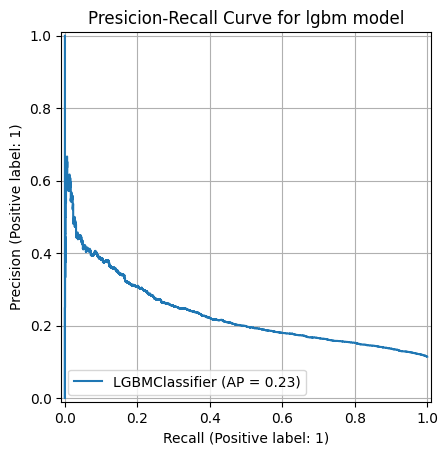

In [52]:
#Plot the Precision-recall curve
PrecisionRecallDisplay.from_estimator(lgbm_model, X_test_km, y_test)
plt.title('Presicion-Recall Curve for lgbm model')
plt.grid(True)
plt.show()

Apply RandomOverSampler

In [53]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_km, y_train)

lgbm_moded_ros = lgb.LGBMClassifier(random_state=42)
lgbm_moded_ros.fit(X_resampled, y_resampled)

y_pred_lgbm_ros = lgbm_moded_ros.predict(X_test_km)

report_all(y_test, y_pred_lgbm_ros, lgbm_moded_ros.predict_proba(X_test_km)[:, 1])

[LightGBM] [Info] Number of positive: 70437, number of negative: 70437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 140874, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[12431  5161]
 [ 1058  1219]]
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     17592
           1       0.19      0.54      0.28      2277

    accuracy                           0.69     19869
   macro avg       0.56      0.62      0.54     19869
weighted avg       0.84      0.69      0.74     19869

ROC AUC
0.6712563407170147
PR AUC
0.22732205268697153


Gridsearch

In [54]:
'''
#Gridsearch for LGBM

#Split a validation from TRAIN
X_tr, X_va, y_tr,y_va = train_test_split(
    X_train_km, y_train, test_size = 0.2, stratify = y_train, random_state = 42
)

pw = pos_weight_from_y(y_tr)
lgbm = LGBMClassifier(
    n_estimators = 500, learning_rate = 0.05, random_state = 42,
    scale_pos_weight=pw,n_jobs=1
)

param_grid = {
    'num_leaves': [31, 63, 127],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'min_child_samples': [20, 50, 100],
    'reg_lambda': [0.0, 0.5, 1.0]
}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='average_precision', n_jobs=-1)
grid_search.fit(X_tr, y_tr)
best_lgbm = grid_search.best_estimator_

print('Best parameters found ', grid_search.best_params_)
print('Best score found ', grid_search.best_score_)

prob_va = best_lgbm.predict_proba(X_va)[:, 1]
t_star, f1_star = tune_threshold_for_f1(y_va.values, prob_va)

best_lgbm.fit(X_train_km, y_train)
proba_test = best_lgbm.predict_proba(X_test_km)[:, 1]
yhat_test = (proba_test >= t_star).astype(int)

print('Model evaluation after grid search')
report_all(y_test, yhat_test, proba_test)
'''

"\n#Gridsearch for LGBM\n\n#Split a validation from TRAIN\nX_tr, X_va, y_tr,y_va = train_test_split(\n    X_train_km, y_train, test_size = 0.2, stratify = y_train, random_state = 42\n)\n\npw = pos_weight_from_y(y_tr)\nlgbm = LGBMClassifier(\n    n_estimators = 500, learning_rate = 0.05, random_state = 42,\n    scale_pos_weight=pw,n_jobs=1\n)\n\nparam_grid = {\n    'num_leaves': [31, 63, 127],\n    'subsample': [0.7, 0.9, 1.0],\n    'colsample_bytree': [0.7, 0.9, 1.0],\n    'min_child_samples': [20, 50, 100],\n    'reg_lambda': [0.0, 0.5, 1.0]\n}\n\ngrid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='average_precision', n_jobs=-1)\ngrid_search.fit(X_tr, y_tr)\nbest_lgbm = grid_search.best_estimator_\n\nprint('Best parameters found ', grid_search.best_params_)\nprint('Best score found ', grid_search.best_score_)\n\nprob_va = best_lgbm.predict_proba(X_va)[:, 1]\nt_star, f1_star = tune_threshold_for_f1(y_va.values, prob_va)\n\nbest_lgbm.fit(X_train_km, y_train)

#XGBoost

In [55]:
import xgboost as xgb

#Initialize with XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

#Fit the model
xgb_model.fit(X_train_km, y_train)

#Execute
y_pred_xgb = xgb_model.predict(X_test_km)

#Model evaluation based on XGBoost
report_all(y_test, y_pred_xgb, xgb_model.predict_proba(X_test_km)[:, 1])


[[17508    84]
 [ 2209    68]]
Classification report: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17592
           1       0.45      0.03      0.06      2277

    accuracy                           0.88     19869
   macro avg       0.67      0.51      0.50     19869
weighted avg       0.84      0.88      0.84     19869

ROC AUC
0.6642878804854604
PR AUC
0.2175639643628633


Randomoversampling

In [56]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_km, y_train)

xgb_model_ros = xgb.XGBClassifier(random_state=42)
xgb_model_ros.fit(X_resampled, y_resampled)

y_pred_xgb_ros = xgb_model_ros.predict(X_test_km)

report_all(y_test, y_pred_xgb_ros, xgb_model_ros.predict_proba(X_test_km)[:, 1])

[[12920  4672]
 [ 1175  1102]]
Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.73      0.82     17592
           1       0.19      0.48      0.27      2277

    accuracy                           0.71     19869
   macro avg       0.55      0.61      0.54     19869
weighted avg       0.83      0.71      0.75     19869

ROC AUC
0.6528659646467643
PR AUC
0.21340580093426953


#Gaussian NB

In [57]:
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
gnb.fit(X_train_km, y_train)
y_pred_gnb = gnb.predict(X_test_km)

proba_test = gnb.predict_proba(X_test_km)[:, 1]
pred_test_05 = (proba_test >= 0.5).astype(int)


print('Model evaluation based on Gaussian NB')
print('confusion Matrix')
print(confusion_matrix(y_test, y_pred_gnb))
print('Classification report')
print(classification_report(y_test, y_pred_gnb))
print('ROC AUC')
print(roc_auc_score(y_test, proba_test))
print('PR AUC')


print(average_precision_score(y_test, proba_test))

Model evaluation based on Gaussian NB
confusion Matrix
[[  810 16782]
 [   78  2199]]
Classification report
              precision    recall  f1-score   support

           0       0.91      0.05      0.09     17592
           1       0.12      0.97      0.21      2277

    accuracy                           0.15     19869
   macro avg       0.51      0.51      0.15     19869
weighted avg       0.82      0.15      0.10     19869

ROC AUC
0.6009562277579361
PR AUC
0.14660553334661636


#Stacking

**Model1: LR + Lgbm + gnb**

In [58]:
#small validation split
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB


X_tr, X_va, y_tr, y_va = train_test_split(
    X_train_km, y_train, test_size = 0.2, stratify = y_train, random_state = 42
)


# Base learners (diverse) + meta learner
lgbm = LGBMClassifier(
    n_estimators = 900, learning_rate = 0.05, num_leaves = 63,
    subsample =0.8, colsample_bytree=0.8,
    scale_pos_weight=pos_weight_from_y(y_tr), random_state=42
)

# Specify a solver that supports l1 penalty
logit = LogisticRegression(penalty = 'l1', class_weight = 'balanced', max_iter=1000, solver='liblinear')
gnb = GaussianNB()

stack = StackingClassifier(
    estimators = [('lr', logit), ('lgbm', lgbm), ('gnb', gnb)],
    final_estimator = LogisticRegression(class_weight='balanced', max_iter=1000),
    cv = 3,
    stack_method = 'predict_proba', #pass probabilities to the meta-learner
    n_jobs = 1,passthrough=True # internal CV for meta-features
)

cal = CalibratedClassifierCV(estimator=stack, method='sigmoid', cv=3)
cal.fit(X_tr, y_tr)

def find_best_threshold_for_f1(y_true, proba, grid=np.linspace(0.05,0.40,39)):
  best_t, best_f1 = 0.5,-1
  for t in grid:
    pred = (proba >=t).astype(int)
    f1 = f1_score(y_true, pred)
    if f1 > best_f1:
      best_f1, best_t = f1,t
  return best_t, best_f1

proba_va = cal.predict_proba(X_va)[:, 1]
t_star, f1_star = find_best_threshold_for_f1(y_va.values, proba_va)
print(f"[Val] best threshold for F1 = {t_star:.2f} (F1 = {f1_star:.3f})")

cal.fit(X_train_km, y_train)
proba_test = cal.predict_proba(X_test_km)[:, 1]
pred_test_05 = (proba_test >= t_star).astype(int)

print('Model evaluation based on Stacking')
print('confusion Matrix')
print(confusion_matrix(y_test, pred_test_05))
print('Classification report')
print(classification_report(y_test, pred_test_05))
print('ROC AUC')
print(roc_auc_score(y_test, proba_test))
print('PR AUC')
print(average_precision_score(y_test, proba_test))

[LightGBM] [Info] Number of positive: 4820, number of negative: 37566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 42386, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113717 -> initscore=-2.053325
[LightGBM] [Info] Start training from score -2.053325
[LightGBM] [Info] Number of positive: 3213, number of negative: 25044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 28257, number of used features: 186
[LightGBM] [Info] 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 4820, number of negative: 37566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1510
[LightGBM] [Info] Number of data points in the train set: 42386, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113717 -> initscore=-2.053325
[LightGBM] [Info] Start training from score -2.053325
[LightGBM] [Info] Number of positive: 3213, number of negative: 25044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1485
[LightGBM] [Info] Number of data points in the train set: 28257, number of used features: 186
[LightGBM] [Info] 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 4820, number of negative: 37566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 42386, number of used features: 191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113717 -> initscore=-2.053325
[LightGBM] [Info] Start training from score -2.053325
[LightGBM] [Info] Number of positive: 3213, number of negative: 25044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 28257, number of used features: 185
[LightGBM] [Info] 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Val] best threshold for F1 = 0.14 (F1 = 0.285)
[LightGBM] [Info] Number of positive: 6024, number of negative: 46958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 52982, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113699 -> initscore=-2.053502
[LightGBM] [Info] Start training from score -2.053502
[LightGBM] [Info] Number of positive: 4016, number of negative: 31305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 35321,

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 6025, number of negative: 46958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1521
[LightGBM] [Info] Number of data points in the train set: 52983, number of used features: 194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113716 -> initscore=-2.053336
[LightGBM] [Info] Start training from score -2.053336
[LightGBM] [Info] Number of positive: 4017, number of negative: 31305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 35322, number of used features: 188
[LightGBM] [Info] 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 6025, number of negative: 46958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 52983, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.113716 -> initscore=-2.053336
[LightGBM] [Info] Start training from score -2.053336
[LightGBM] [Info] Number of positive: 4017, number of negative: 31305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 35322, number of used features: 190
[LightGBM] [Info] 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model evaluation based on Stacking
confusion Matrix
[[14323  3269]
 [ 1369   908]]
Classification report
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     17592
           1       0.22      0.40      0.28      2277

    accuracy                           0.77     19869
   macro avg       0.57      0.61      0.57     19869
weighted avg       0.83      0.77      0.79     19869

ROC AUC
0.6755607211965834
PR AUC
0.2231376708141799


In [59]:
def prob_diagnostics(proba, y_true):
  qs = [0.5, 0.8, 0.9, 0.95, 0.99]
  print('baseline positive rate(train/test):', np.mean(y_true).round(4))
  print('proba quantiles:', {q: np.quantile(proba, q).round(4) for q in qs})
  print('predicted positives at t=0.5: ', int((proba >= 0.5).sum()))

prob_diagnostics(proba_va, y_va.values)
prob_diagnostics(proba_test, y_test.values)




baseline positive rate(train/test): 0.1137
proba quantiles: {0.5: np.float64(0.0976), 0.8: np.float64(0.142), 0.9: np.float64(0.1766), 0.95: np.float64(0.2202), 0.99: np.float64(0.3728)}
predicted positives at t=0.5:  58
baseline positive rate(train/test): 0.1146
proba quantiles: {0.5: np.float64(0.0966), 0.8: np.float64(0.1446), 0.9: np.float64(0.183), 0.95: np.float64(0.2248), 0.99: np.float64(0.3696)}
predicted positives at t=0.5:  70


In [62]:
'''
from sklearn.svm import SVC

rf = RandomForestClassifier(max_depth = 25, n_estimators = 150, class_weight = 'balanced', random_state=42)

stack_2 = StackingClassifier(
    estimators = [('lr', logit), ('rf', rf), ('lgbm', lgbm)],
    final_estimator = LogisticRegression(class_weight='balanced', max_iter=2000),
    cv = 5,
    stack_method = 'predict_proba', #pass probabilities to the meta-learner
    n_jobs = 1, passthrough=True
)


stack_2.fit(X_tr, y_tr)
proba_va = stack_2.predict_proba(X_va)[:, 1]
t_star, f1_star = find_best_threshold_for_f1(y_va.values, proba_va)


stack_2.fit(X_train_km, y_train)
proba_test = stack_2.predict_proba(X_test_km)[:, 1]
pred_test_05 = (proba_test >= t_star).astype(int)

print('Model evaluation based on Stacking')
print('confusion Matrix')
print(confusion_matrix(y_test, pred_test_05))
print('Classification report')
print(classification_report(y_test, pred_test_05))
print('ROC AUC')
print(roc_auc_score(y_test, proba_test))
print('PR AUC')
print(average_precision_score(y_test, proba_test))
'''

"\nfrom sklearn.svm import SVC\n\nrf = RandomForestClassifier(max_depth = 25, n_estimators = 150, class_weight = 'balanced', random_state=42)\n\nstack_2 = StackingClassifier(\n    estimators = [('lr', logit), ('rf', rf), ('lgbm', lgbm)],\n    final_estimator = LogisticRegression(class_weight='balanced', max_iter=2000),\n    cv = 5,\n    stack_method = 'predict_proba', #pass probabilities to the meta-learner\n    n_jobs = 1, passthrough=True\n)\n\n\nstack_2.fit(X_tr, y_tr)\nproba_va = stack_2.predict_proba(X_va)[:, 1]\nt_star, f1_star = find_best_threshold_for_f1(y_va.values, proba_va)\n\n\nstack_2.fit(X_train_km, y_train)\nproba_test = stack_2.predict_proba(X_test_km)[:, 1]\npred_test_05 = (proba_test >= t_star).astype(int)\n\nprint('Model evaluation based on Stacking')\nprint('confusion Matrix')\nprint(confusion_matrix(y_test, pred_test_05))\nprint('Classification report')\nprint(classification_report(y_test, pred_test_05))\nprint('ROC AUC')\nprint(roc_auc_score(y_test, proba_test))\n

Appendix Kmeans evaluation

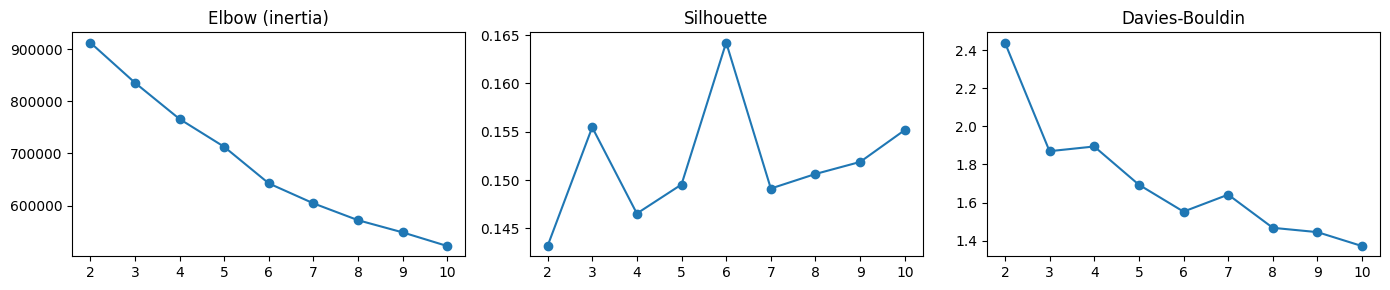

In [61]:
ks = range(2,11)
inertia = []
silhouette = []
db_score = []

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    labels = kmeans.fit_predict(Z_train)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(Z_train, labels))
    db_score.append(davies_bouldin_score(Z_train, labels))

fig, ax = plt.subplots(1,3,figsize=(14,3))
ax[0].plot(ks,inertia,marker = "o"); ax[0].set_title('Elbow (inertia)')
ax[1].plot(ks,silhouette,marker = "o"); ax[1].set_title('Silhouette')
ax[2].plot(ks,db_score,marker = "o"); ax[2].set_title('Davies-Bouldin')
plt.tight_layout()
plt.show()